In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)

In [2]:
def batch2counts(batch,k):
    counts = np.zeros((batch.shape[0], k))
    for i in range(k):
        counts[:, i] = (batch==i).sum(1)
    return counts

class MAPCategorical:
    
    def __init__(self, probs, n0):
        self.probs=probs
        self.n = n0
        
    def update(self, batch):
        k = self.probs.shape[-1]
        if batch.shape[-1]==1:
            self.probs = (self.n*self.probs + np.eye(k)[batch.squeeze(-1)]) /(self.n +1)
            self.n += 1
        else:
            counts = batch2counts(batch, k)
            nn = self.n + counts.sum()
            self.probs = (self.n*self.probs + counts) / nn
            self.n = nn

In [3]:
k=5
m=2
mapc = MAPCategorical(probs=np.random.dirichlet(np.ones(k),size=m), n0=10)
print(mapc.probs)
batch = np.random.randint(low=0, high=k, size=(m,1))
mapc.update(batch)
print(mapc.probs)
mapc.update(np.zeros((m,1000), dtype=np.int))
print(mapc.probs)

[[0.05 0.3  0.43 0.18 0.03]
 [0.09 0.03 0.   0.77 0.1 ]]
[[0.14 0.27 0.39 0.17 0.03]
 [0.08 0.03 0.09 0.7  0.09]]
[[4.98e-01 1.50e-03 2.14e-03 9.18e-04 1.51e-04]
 [4.98e-01 1.40e-04 5.17e-04 3.84e-03 5.18e-04]]


In [4]:
from categorical.utils import logit2proba, proba2logit, logsumexp


class SGDCategorical():
    
    def __init__(self, logits, stepsize, scheduler_exponent=0):
        self.logits = logits - logits.mean(-1, keepdims=True)
        self.stepsize = stepsize
        self.scheduler_exponent = scheduler_exponent
           
        self.average_logits = self.logits
        self.step = 1
        
    def update(self, batch):
        
        # get gradient
        k = self.logits.shape[-1]
        if batch.shape[-1]==1:
            frequencies = np.eye(k)[batch.squeeze(-1)]
        else:
            counts = batch2counts(batch, k)
            frequencies = counts / np.sum(counts, -1 ,keepdims=True)
        gradient = logit2proba(self.logits) - frequencies 
        
        # update
        stepsize = self.stepsize / self.step ** self.scheduler_exponent
        self.logits -= stepsize * gradient
        
        self.average_logits = (self.step * self.average_logits + self.logits)/(self.step + 1)
        self.step += 1

In [5]:
reference = np.random.randn(m,k)
sgdc = SGDCategorical(reference,1)
print(sgdc.logits)
batch = np.random.randint(low=0, high=k, size=(m,15))
sgdc.update(batch)
sgdc.update(np.zeros((m,1000)))
print(sgdc.logits)

[[ 0.13  0.95 -0.61  0.82 -1.28]
 [-1.61  0.09  0.29  0.38  0.84]]
[[ 0.87  0.43 -0.64  0.46 -1.11]
 [-0.61 -0.    0.07  0.13  0.41]]


In [6]:
def kl_proba(p1, p2):
    return np.sum(p1 * np.log(p1 / p2), axis=-1)

def kl_logits(s1, s2):
    return np.sum(logit2proba(s1) * (s1 - s2), axis=-1) - logsumexp(s1) + logsumexp(s2)

In [11]:
def compare_speed(k=3, m=100, n0=10, stepsize=1, schedule=0,
                  max_iter=100, log_interval=1):
    np.random.seed(1)
    torch.manual_seed(1)
    
    # transfer to next one
    probs = np.random.dirichlet(np.ones(k)/k, size=m+1)
    logits = proba2logit(probs)
    transfer = torch.distributions.categorical.Categorical(
        probs=torch.tensor(probs[1:]))

    mapc = MAPCategorical(probs=probs[:-1],n0=n0)
    sgdc = SGDCategorical(logits=logits[:-1],
                          stepsize=stepsize,
                          scheduler_exponent=schedule)

    trajs = {'steps':[], 'MAP': [], 'SGD': [], 'ASGD':[]}
    for step in range(max_iter):    
        if step % log_interval == 0:
            trajs['steps'] += [step]
            trajs['MAP'] += [kl_proba(probs[1:], mapc.probs)]
            trajs['SGD'] += [kl_proba(
                probs[1:], logit2proba(sgdc.logits))]
            trajs['ASGD'] += [kl_proba(
                probs[1:], logit2proba(sgdc.average_logits))]

        batchsize=1
        batch = transfer.sample(torch.tensor([batchsize])).numpy().T
        mapc.update(batch)
        sgdc.update(batch)

    for key, value in trajs.items():
        trajs[key] = np.array(value)
        
    return trajs


trajs = compare_speed(stepsize=2)

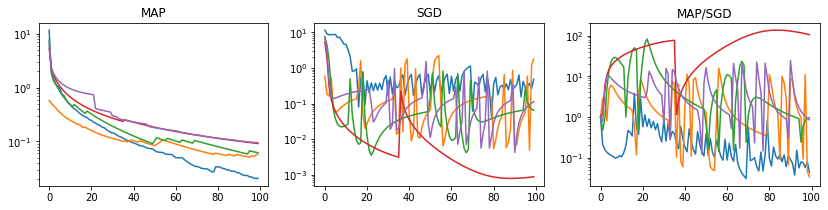

In [12]:
def plot_trajectories(trajs):
    fig, axs = plt.subplots(ncols=3, figsize=(14, 3))
    for ax, title, traj in zip(axs,
                               ['MAP', 'SGD', 'MAP/SGD'],
                               [trajs['MAP'], trajs['SGD'], trajs['MAP']/trajs['SGD']]):
        ax.plot(trajs['steps'], traj[:,:5])
        ax.set_yscale('log')
        ax.set_title(title)
    plt.show()
        
plot_trajectories(trajs)

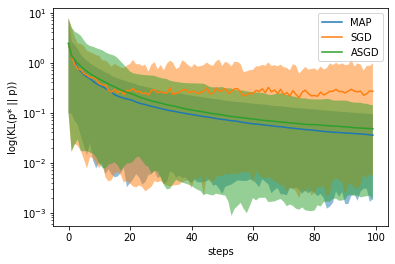

In [13]:
def plot_statistics(trajs):
    xx = trajs['steps']
    for name, traj in trajs.items():
        if name not in ['steps']:
            plt.plot(xx, traj.mean(1), label=name)
            plt.fill_between(
                trajs['steps'], 
                np.percentile(traj,5,1), 
                np.percentile(traj, 95, 1),
                alpha=.5
            )
    # plt.plot(xx[1:], xx[1:]**-.5)
    plt.yscale('log')
    plt.xlabel('steps')
    plt.ylabel('log(KL(p* || p))')
    plt.legend()
        
plot_statistics(trajs)

Now I have the basis to compare speed of MAP and SGD. What is left to do is: do a massive study with many more samples; plotting statistics, and controlling for optimal prior strength and step-size

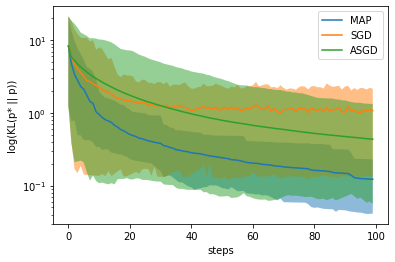

In [26]:
# optimal MAP and ASGD for k=10
plot_statistics(compare_speed(k=10, n0=10, stepsize=4))

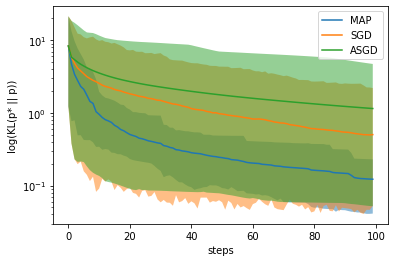

In [15]:
# optimal SGD with rate 1/sqrt(t)
plot_statistics(compare_speed(k=10, n0=10, stepsize=4, schedule=.5))

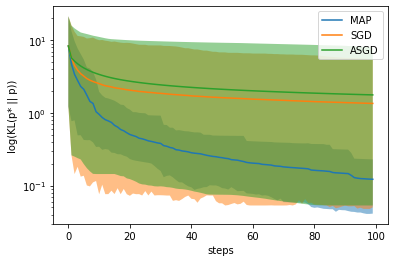

In [16]:
# optimal SGD with rate 1/t
plot_statistics(compare_speed(k=10, n0=10, stepsize=8, schedule=1))

/Users/lepriolr/Drive/phd/causal-optimization/categorical/utils.py:23: RuntimeWarning: divide by zero encountered in log
  s = np.log(p)
/Users/lepriolr/Drive/phd/causal-optimization/categorical/utils.py:24: RuntimeWarning: invalid value encountered in subtract
  s -= np.mean(s, axis=-1, keepdims=True)
/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


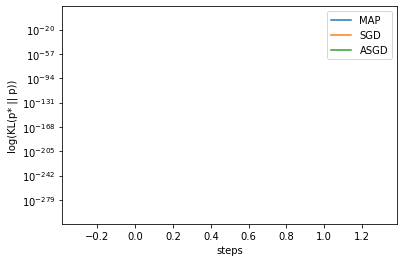

In [17]:
# optimal MAP and ASGD for k=100
plot_statistics(compare_speed(k=100, n0=100, stepsize=5))

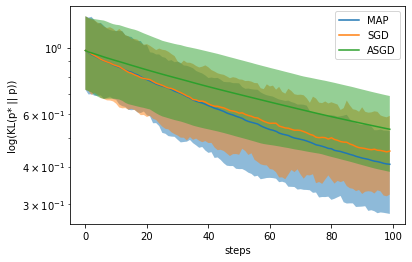

In [40]:
# optimal MAP but suboptimal ASGD and good SGD
plot_statistics(compare_speed(k=100, n0=100, stepsize=1))

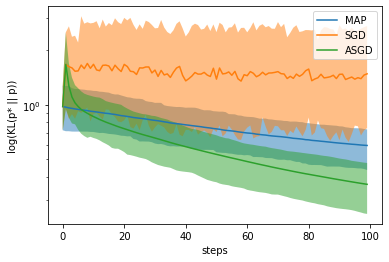

In [41]:
# suboptimal MAP with too narrow prior
plot_statistics(compare_speed(k=100, n0=500, stepsize=5))

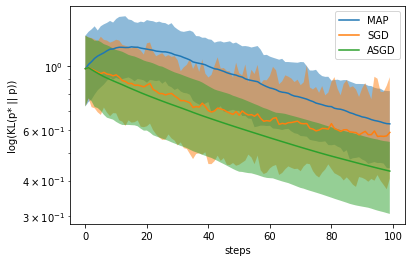

In [42]:
# suboptimal MAP with too wide prior
plot_statistics(compare_speed(k=100, n0=10, stepsize=2))

Very interesting effect: the optimal prior strength depends on the dimension for MAP, whereas an optimal step size for ASGD is always 2, which is the inverse of the smoothness of the softmax loss ! The step size can actually take values between 2 and 8 while keeping performances comparable to the best MAP estimator. For the MAP it seems like $n_0=k$ is generally a good choice. This is obvious a posteriori: our  target can be anywhere on the simplex, so we want our prior to be as much as possible uniform, and this is achieved by setting all the values of alpha to 1. but can only control the scale of alpha, so at least we make the sum of alpha equal to k.

Now can i get similar results for Gaussian variables?

# Gaussians


In [17]:
class MAPGaussian:
    # wrong formulas
    def __init__(self, mean, cov, n0):
        self.mean = mean
        self.cov = cov
        self.n = n0
        
    def update(self, batch):
        k = self.mean.shape
        nn = self.n + batch.shape[0]
        self.mean = (self.n*self.mean + batch.sum(0)) /nn
        self.cov = (self.n * self.cov + np.dot(batch.T, batch))/nn
        self.n = nn 

In [18]:
import scipy.stats
k = 5
mean = np.random.randn(k)
invwish = scipy.stats.invwishart(df=k+10,scale=np.eye(k))
cov = invwish.rvs(1)
cov.shape

(5, 5)

In [19]:
samples = mean + np.dot(np.random.randn(100, k), cov)
print(samples.shape)
mapg = MAPGaussian(np.zeros(k), np.eye(k), 1)
mapg.update(samples)
print(mapg.mean, '\n', mapg.cov.shape)

(100, 5)
[0.19 0.1  0.1  1.31 0.38] 
 (5, 5)


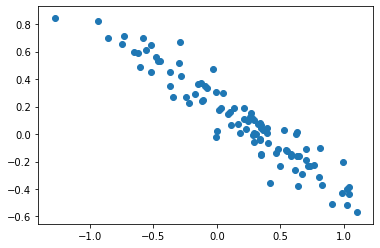

In [20]:
plt.scatter(samples[:,0], samples[:,1])

In [21]:
def compare_gaussians(k=3, m=100, n0=10, stepsize=1,
                  max_iter=100, log_interval=1):
    np.random.seed(1)
    torch.manual_seed(1)
    
    # transfer to next one
    means = np.random.randn(m+1, k)
    invwishart = scipy.stats.invwishart(df=k+10,scale=np.eye(k))
    covs = invwish.rvs(m+1)

    mapc = [MAPCategorical(mean=means[:-1],n0=n0)]
    sgdc = SGDCategorical(logits=logits[:-1],stepsize=stepsize)

    trajs = {'steps':[], 'MAP': [], 'SGD': [], 'ASGD':[]}
    for step in range(max_iter):    
        if step % log_interval == 0:
            trajs['steps'] += [step]
            trajs['MAP'] += [kl_proba(probs[1:], mapc.probs)]
            trajs['SGD'] += [kl_proba(
                probs[1:], logit2proba(sgdc.logits))]
            trajs['ASGD'] += [kl_proba(
                probs[1:], logit2proba(sgdc.average_logits))]

        batchsize=1
        batch = transfer.sample(torch.tensor([batchsize])).numpy().T
        mapc.update(batch)
        sgdc.update(batch)

    for key, value in trajs.items():
        trajs[key] = np.array(value)
        
    return trajs


trajs = compare_speed(stepsize=2)